
# Import & Constant


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import itertools
import warnings
from copy import deepcopy
import re
import ast
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

tqdm.pandas()
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
AMINO_ALPHA = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
AMINO_DETECT = r'[ARNDCEQGHILKMFPSTWYVX*]+'
SUBCLASS_LABEL = ['ACC', 'BLCA', 'BRCA', 'CESC', 'COAD', 'DLBC', 'GBMLGG', 'HNSC', 'KIRC', 'KIPAN', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
                  'OV', 'PAAD', 'PCPG', 'PRAD', 'SARC', 'SKCM', 'STES', 'TGCT', 'THCA', 'THYM', 'UCEC']
SUBCLASS_ENCODED = {v:i for i, v in enumerate(SUBCLASS_LABEL)}

RSEED = 41
np.random.seed(RSEED)

In [3]:
train = pd.read_csv("./drive/MyDrive/Colab Notebooks/dacon_genome/train.csv")
test = pd.read_csv("./drive/MyDrive/Colab Notebooks/dacon_genome/test.csv")
external = pd.read_csv("./drive/MyDrive/Colab Notebooks/dacon_genome/external_df.csv")

In [ ]:
import gc
gc.collect()

136442

### regular expressions

In [4]:
TRAIN_RE = [
    r'^[A-Z*]\d+[A-Z*]$',            # a d a
    r'^\d+_\d+[A-Z*]+>[A-Z*]+$',     # d1 _ d2 al > al
    r'^[A-Z*]\d+fs$',                # a d fs
    r'^-\d+fs$',                     # -d fs
    r'^[A-Z*]+\d+fs$',               # al d fs
    r'^\d+del$',                     # d del
]

EXT_RE = [
    r'^[A-Z*]\d+[A-Z*]$',                   # a d a
    r'^\d+_\d+[A-Z*]+>[A-Z*]+$',            # d1 _ d2 al > al
    r'^[A-Z*]\d+fs$',                       # a d fs
    r'^[A-Z*]\d+del$',                      # a d del
    r'^[A-Z*]\d+_[A-Z*]\d+del$',            # a d1 _ a d2 del
    r'^[A-Z*]\d+_[A-Z*]\d+ins[A-Z*]+$',     # a d1 _ a d2 ins al
    r'^[A-Z*]\d+delins[A-Z*]+$',            # a d1 delins al
    r'^[A-Z*]\d+_[A-Z*]\d+delins[A-Z*]+$',  # a d1 _ a d2 delins al
]

# External Data Preprocessing (셀 실행하지 마세요)

In [ ]:
# patterns = [
#     r'^[A-Z*]\d+[A-Z*]$',         # a d a
#     r'^\d+_\d+[A-Z*]+>[A-Z*]+$',     # d1 _ d2 al > al
#     r'^[A-Z*]\d+fs$',                # a d fs
#     r'^-\d+fs$',                     # -d fs
#     r'^[A-Z*]\d+del$',                      # a d del
#     r'^[A-Z*]\d+_[A-Z*]\d+del$',            # a d1 _ a d2 del
#     r'^[A-Z*]\d+_[A-Z*]\d+ins[A-Z*]+$',     # a d1 _ a d2 ins al
#     r'^[A-Z*]\d+delins[A-Z*]+$',            # a d1 delins al
#     r'^[A-Z*]\d+_[A-Z*]\d+delins[A-Z*]+$',  # a d1 _ a d2 delins al
# ]

# def hgvs_formatting(hgvs:str, delins):
#   if type(hgvs) == float: return 0
#   if sum([x in hgvs for x in ['splice', 'ext', 'dup']]): return 0
#   if hgvs[0] == '*' == hgvs[-1]: return 0
#   if delins and sum([x in hgvs for x in ['del', 'ins']]):
#     return 0
#   #
#   hgvs_ = hgvs[2:]
#   hgvs_ = hgvs_.replace('?', 'X')
#   hgvs_ = hgvs_.replace('=', hgvs_[0])
#   if 'fs' in hgvs_: hgvs_ = hgvs_.split('fs')[0][:-1] + 'fs'
#   #debug
#   # if re.match(r'^[A-Z*]{2,}\d+fs$', hgvs_): print(hgvs)
#   #
#   if not any(re.match(pattern, hgvs_) for pattern in patterns) or hgvs[:2] != 'p.':
#     if re.match(r'^[A-Z*]\d+fs$', hgvs): return hgvs
#     else: return 0
#   #
#   return hgvs_

# def add_mut(add_str, org_str):
#     if org_str == 'WT': return add_str
#     else: return org_str + ' ' + add_str

# def ext_modification(cancer_name:str, ext):
#   ind = ext['Tumor_Sample_Barcode'].unique(); col = test.columns[1:].tolist()
#   ind = {x:i for i, x in enumerate(ind)}; col = {x:i for i, x in enumerate(col)}
#   output = np.full(shape=(len(ext['Tumor_Sample_Barcode'].unique()), len(test.columns)-1), fill_value='WT', dtype='object')
#   passed_gene = set(); in_gene = set(); delins_cut = True

#   for ser in ext[['Tumor_Sample_Barcode', 'Hugo_Symbol', 'HGVSp_Short']].iterrows():
#       ser = ser[1]
#       if ser['Hugo_Symbol'] in test.columns:
#           formatted = hgvs_formatting(ser['HGVSp_Short'], delins_cut)
#           if not formatted: continue
#           in_gene.add(ser['Hugo_Symbol'])
#           r, c = ind[ser['Tumor_Sample_Barcode']], col[ser['Hugo_Symbol']]
#           output[r][c] = add_mut(formatted, output[r][c])
#       else:
#         passed_gene.add(ser['Hugo_Symbol'])

#   print(f" ####### for {cancer_name}:", len(in_gene), '/', len(passed_gene), '#######')
#   ext_modified = pd.DataFrame(output, columns=test.columns[1:])
#   return ext_modified

In [ ]:
# cancer_list = ['sarc', 'skcm', 'kirc', 'gbm', 'brca', 'thca', 'lihc', 'hnsc', 'paad', 'ov', 'prad', 'ucec', 'laml',
#                'coad', 'acc', 'lgg', 'lusc', 'luad', 'cesc', 'pcpg', 'thym', 'blca', 'tgct', 'dlbc',
#                'esca', 'stad', 'kirp', 'kich']

# l = []
# for cancer_name in tqdm(cancer_list):
#   ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
#   result = ext_modification(cancer_name, ext)
#   if cancer_name in ['esca', 'stad']:
#     result['SUBCLASS'] = 'STES'
#   elif cancer_name in ['kirp', 'kich']:
#     result['SUBCLASS'] = 'KIPAN'
#   elif cancer_name == 'gbm':
#     result['SUBCLASS'] = 'GBMLGG'
#   else:
#     result['SUBCLASS'] = cancer_name.upper()
#   l.append(result)

# result = pd.concat(l, axis=0)
# result.to_csv("./drive/MyDrive/Colab Notebooks/dacon_genome/external_df_indel.csv", index=False)

  4%|▎         | 1/28 [00:02<01:06,  2.46s/it]

 ####### for sarc: 1814 / 8343 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (46,67,89) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
  7%|▋         | 2/28 [00:39<10:00, 23.08s/it]

 ####### for skcm: 4036 / 15170 #######


 11%|█         | 3/28 [00:44<06:06, 14.66s/it]

 ####### for kirc: 2902 / 10653 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 14%|█▍        | 4/28 [00:49<04:16, 10.70s/it]

 ####### for gbm: 2141 / 7556 #######


 18%|█▊        | 5/28 [01:01<04:18, 11.22s/it]

 ####### for brca: 3648 / 13934 #######


 21%|██▏       | 6/28 [01:02<02:49,  7.71s/it]

 ####### for thca: 1127 / 3800 #######


 25%|██▌       | 7/28 [01:06<02:20,  6.68s/it]

 ####### for lihc: 3382 / 11458 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 29%|██▊       | 8/28 [01:19<02:50,  8.54s/it]

 ####### for hnsc: 3855 / 13990 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (4,51,94,135,172,243) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 32%|███▏      | 9/28 [01:24<02:22,  7.50s/it]

 ####### for paad: 2830 / 8751 #######


 36%|███▌      | 10/28 [01:26<01:43,  5.72s/it]

 ####### for ov: 2250 / 7742 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 39%|███▉      | 11/28 [01:30<01:27,  5.14s/it]

 ####### for prad: 2930 / 10534 #######


 43%|████▎     | 12/28 [01:46<02:15,  8.50s/it]

 ####### for ucec: 4060 / 15078 #######


 46%|████▋     | 13/28 [01:46<01:30,  6.03s/it]

 ####### for laml: 384 / 1492 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 50%|█████     | 14/28 [01:54<01:33,  6.67s/it]

 ####### for coad: 3692 / 12246 #######


 54%|█████▎    | 15/28 [01:56<01:07,  5.16s/it]

 ####### for acc: 1863 / 6802 #######


 57%|█████▋    | 16/28 [01:57<00:46,  3.87s/it]

 ####### for lgg: 1307 / 4614 #######


 61%|██████    | 17/28 [02:03<00:49,  4.52s/it]

 ####### for lusc: 3321 / 11625 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (50,57,59,61,71,95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 64%|██████▍   | 18/28 [02:11<00:57,  5.71s/it]

 ####### for luad: 3385 / 11640 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (52,53,56,72,77,81,95,100,101,103) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 68%|██████▊   | 19/28 [02:16<00:47,  5.32s/it]

 ####### for cesc: 3104 / 12984 #######


 71%|███████▏  | 20/28 [02:16<00:31,  3.88s/it]

 ####### for pcpg: 639 / 2520 #######


 75%|███████▌  | 21/28 [02:17<00:19,  2.81s/it]

 ####### for thym: 426 / 2020 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (50,58,61,71,77,94) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 79%|███████▊  | 22/28 [02:22<00:21,  3.55s/it]

 ####### for blca: 3059 / 10276 #######


 82%|████████▏ | 23/28 [02:23<00:14,  2.87s/it]

 ####### for tgct: 1602 / 5857 #######


 86%|████████▌ | 24/28 [02:25<00:09,  2.44s/it]

 ####### for dlbc: 1874 / 6765 #######


 89%|████████▉ | 25/28 [02:29<00:09,  3.16s/it]

 ####### for esca: 3256 / 13371 #######


<ipython-input-30-44eb1b8de83b>:7: DtypeWarning: Columns (56,61,65) have mixed types. Specify dtype option on import or set low_memory=False.
  ext = pd.read_csv(f"./drive/MyDrive/Colab Notebooks/dacon_genome/externals/tcga/data_mutations_{cancer_name}.txt", sep='\t')
 93%|█████████▎| 26/28 [02:50<00:16,  8.36s/it]

 ####### for stad: 4076 / 15480 #######


 96%|█████████▋| 27/28 [02:52<00:06,  6.37s/it]

 ####### for kirp: 2256 / 7311 #######


100%|██████████| 28/28 [02:52<00:00,  6.17s/it]

 ####### for kich: 1028 / 3711 #######


# Data Preprocessing

## Data Cleansing

In [5]:
X_tr, y_tr = train.iloc[:, 2:], train['SUBCLASS']
X_ext, y_ext = external.iloc[:, :-1], external['SUBCLASS']
X_te = test.iloc[:, 1:]

# na값 WT로 채우기
X_te = X_te.fillna('WT')

# 모두 WT인 행 제거
y_tr = y_tr.loc[~(X_tr == 'WT').all(axis=1)]
X_tr = X_tr.loc[~(X_tr == 'WT').all(axis=1)]
y_ext = y_ext.loc[~(X_ext == 'WT').all(axis=1)]
X_ext = X_ext.loc[~(X_ext == 'WT').all(axis=1)]

# 정규 표현식에 맞지 않는 값 제거
def search_exceptions(st, re_exp):
  for mutexp in st.split(' '):
    if mutexp == 'WT': continue
    if not any(re.match(pattern, mutexp) for pattern in re_exp):
      return True
  return False

tr_exception = X_tr.map(lambda x: search_exceptions(x, TRAIN_RE))
ext_exception = X_ext.map(lambda x: search_exceptions(x, EXT_RE))
print(f"TRAIN: There are {tr_exception.sum().sum()} exceptions.")
print(f"EXT: There are {ext_exception.sum().sum()} exceptions.")
X_tr[tr_exception] = 'WT'
X_ext[ext_exception] = 'WT'

X_tr = X_tr.rename(lambda x: f'train_{x}', axis='index')
X_te = X_te.rename(lambda x: f'test_{x}', axis='index')
X_ext = X_ext.rename(lambda x: f'ext_{x}', axis='index')
y_tr = y_tr.rename(lambda x: f'train_{x}', axis='index')
y_ext = y_ext.rename(lambda x: f'ext_{x}', axis='index')

X_all = pd.concat([X_tr, X_ext, X_te], axis=0)
y_all = pd.concat([y_tr, y_ext], axis=0)

# train과 external에서 모두 WT인 열 제거
X_all = X_all.loc[:, ~((X_tr == 'WT').all(axis=0) | (X_ext == 'WT').all(axis=0))]

def del_dup_WT(x):
  x = str(x); xl = x.split(' '); flag = True; result = []
  for st in xl:
    if st == 'WT': continue
    else: result.append(st); flag = False
  if flag: return 'WT'
  else: return ' '.join(result)

X_all = X_all.map(del_dup_WT)

TRAIN: There are 1 exceptions.
EXT: There are 0 exceptions.


## Feature Engineering

### 4. 변이 종류 별로 등장한 아미노산

In [18]:
def mutkind(x:str):
  if any(st in x for st in ['fs', 'ins', 'del']):
    return 'FS'
  elif '*' in x:
    return 'ST'
  elif '>' in x or (x[0] != x[-1] and 'WT' != x):
    try: al1, al2 = re.findall(AMINO_DETECT, x)
    except: return 'M'
    if al1 == al2: return 'S'
    else: return 'M'
  elif x[0] == x[-1]:
    return 'S'
  #
  return 'WT'

def count_prefixes_in_row(row: pd.Series):
    counts = {k:{p: 0 for p in AMINO_ALPHA} for k in ['FS', 'ST', 'S', 'M', 'MT']}
    #
    def count_prefixes(allmut):
      for mut in allmut.split():
        mk = mutkind(mut)
        aminos = re.findall(AMINO_DETECT, mut)
        if mk != 'WT' and len(aminos):
          if aminos[0][0] in AMINO_ALPHA:
            counts[mk][aminos[0][0]] += 1
            if mk == 'M' and len(aminos) == 2 and aminos[1][0] in AMINO_ALPHA:
              counts['MT'][aminos[1][0]] += 1
    #
    row.apply(lambda allmut: count_prefixes(allmut))
    flattened_dict = {f"{k}_{p}": v for k, inner_dict in counts.items() for p, v in inner_dict.items()}
    return pd.Series(flattened_dict)

X_feature_4 = X_all.progress_apply(count_prefixes_in_row, axis=1)

100%|██████████| 16353/16353 [04:36<00:00, 59.17it/s]


### 5. Binning Feature 추가, 행별 변이 개수 카운트

In [7]:
def name_change(name):
  mlist = name.split()
  muts = [0, 0, 0, 0]

  for x in mlist:
    if 'fs' in x:
      muts[0] += 1
    elif 'ins' in x:
      muts[0] += 1
    elif 'del' in x:
      muts[0] += 1
    elif '*' in x:
      muts[1] += 1
    elif '>' in x or (x[0] != x[-1] and 'WT' != x):
      muts[2] += 1
    elif x[0] == x[-1]:
      muts[3] += 1

  muts = [k if 9 > k else 9 for k in muts]
  result = int(f"{muts[0]}{muts[1]}{muts[2]}{muts[3]}")
  return result

X_feature_5 = X_all.progress_applymap(name_change)

100%|██████████| 69091425/69091425 [04:08<00:00, 278509.49it/s]


In [8]:
def adding_columns(df_old):
  df_new = dict()
  df_new["sum_up"] = df_old.sum(axis=1)
  df_new["count_up"] = (df_old != 0).sum(axis=1)
  df_new["maximum"] = df_old.max(axis=1)
  df_new['FS_num'] = (df_old >= 1000).sum(axis=1)
  df_new['NS_num'] = ((df_old >= 100) & (df_old < 1000)).sum(axis=1)
  df_new['MS_num'] = ((df_old >= 10) & (df_old < 100)).sum(axis=1)
  df_new['SI_num'] = ((df_old >= 1) & (df_old < 10)).sum(axis=1)
  df_new["WT_num"] = (df_old == 0).sum(axis=1)

  df_new['1'] = (df_old == 1).sum(axis=1)
  df_new['2-10'] = ((df_old >= 2) & (df_old < 10)).sum(axis=1)

  df_new['10-20'] = ((df_old >= 10) & (df_old < 20)).sum(axis=1)
  df_new['20-100'] = ((df_old >= 20) & (df_old < 100)).sum(axis=1)

  df_new['100-200'] = ((df_old >= 100) & (df_old < 200)).sum(axis=1)
  df_new['200-1000'] = ((df_old >= 200) & (df_old < 1000)).sum(axis=1)

  df_new['1000-2000'] = ((df_old >= 1000) & (df_old < 2000)).sum(axis=1)
  df_new['2000-10000'] = ((df_old >= 2000) & (df_old < 10000)).sum(axis=1)

  return pd.DataFrame(df_new, index=df_old.index)

X_feature_6 = adding_columns(X_feature_5)

### 6. For KIPAN, KIRC

In [ ]:
l = []
for g in ['VHL', 'DST', 'KMT2D', 'MTOR', 'PABPC1', 'PCLO', 'MET', 'PTEN', 'RYR1']:
  temp = pos_for_gene(X_all[g])
  temp.name = f'{g}_pos'
l.append(temp)
l.append(genefeatures(['VHL', 'DST', 'KMT2D', 'MTOR', 'PABPC1', 'PCLO', 'MET', 'PTEN', 'RYR1']))

X_feature_9 = pd.concat(l, axis=1)

## Concatenating Dataframes(Features) & Delete Duplicants

In [19]:
features = [
    # X_feature_1,
    # X_feature_2,
    # X_feature_3,
    X_feature_4,
    X_feature_5,
    X_feature_6,
    # X_feature_7,
    # X_feature_8,
    # X_feature_9,
    # X_feature_10,
]

features_K = [
    # X_feature_1,
    # X_feature_2,
    # X_feature_3,
    # X_feature_4,
    # X_feature_5,
    X_feature_6,
    # X_feature_7,
    # X_feature_8,
    # X_feature_9,
    # X_feature_10,
]

X_all_final = pd.concat(features, axis=1)
X_all_final_K = pd.concat(features_K, axis=1)
# feature selection
# X_all_final.drop(['TP53'], inplace=True, axis=1)
#
X_tr_final = X_all_final.iloc[:-len(X_te)]; X_te_final = X_all_final.iloc[-len(X_te):]
y_tr_final = pd.concat([y_tr, y_ext], axis=0)
X_tr_final_K = X_all_final_K.iloc[:-len(X_te)]; X_te_final_K = X_all_final_K.iloc[-len(X_te):]

# Sampling & Model Training

## k-fold CV

In [ ]:
LGBM_PARAM = dict(
    boosting_type='gbdt',
    num_leaves=40,
    verbose=-1,
    reg_alpha=0.01,
    reg_lambda=0.1,
    n_estimators=400,
    learning_rate=0.1,
    min_child_samples=20,
    importance_type='gain',
    class_weight='balanced',
    # min_split_gain=1,
    # early_stopping_round=10,
    min_child_weight=1e-3
)
LGBM_PARAM_K = dict(
    boosting_type='dart',
    # num_leaves=10,
    verbose=-1,
    reg_alpha=0,
    reg_lambda=0,
    n_estimators=300,
    learning_rate=0.1,
    # min_child_samples=30,
    # importance_type='gain',
    max_depth=7,
    # colsample_bytree=0.3
)

### Fold 1 ### Macro F1 Score: 0.70519954793005
### Fold 2 ### Macro F1 Score: 0.7162354448246177


KeyboardInterrupt: 

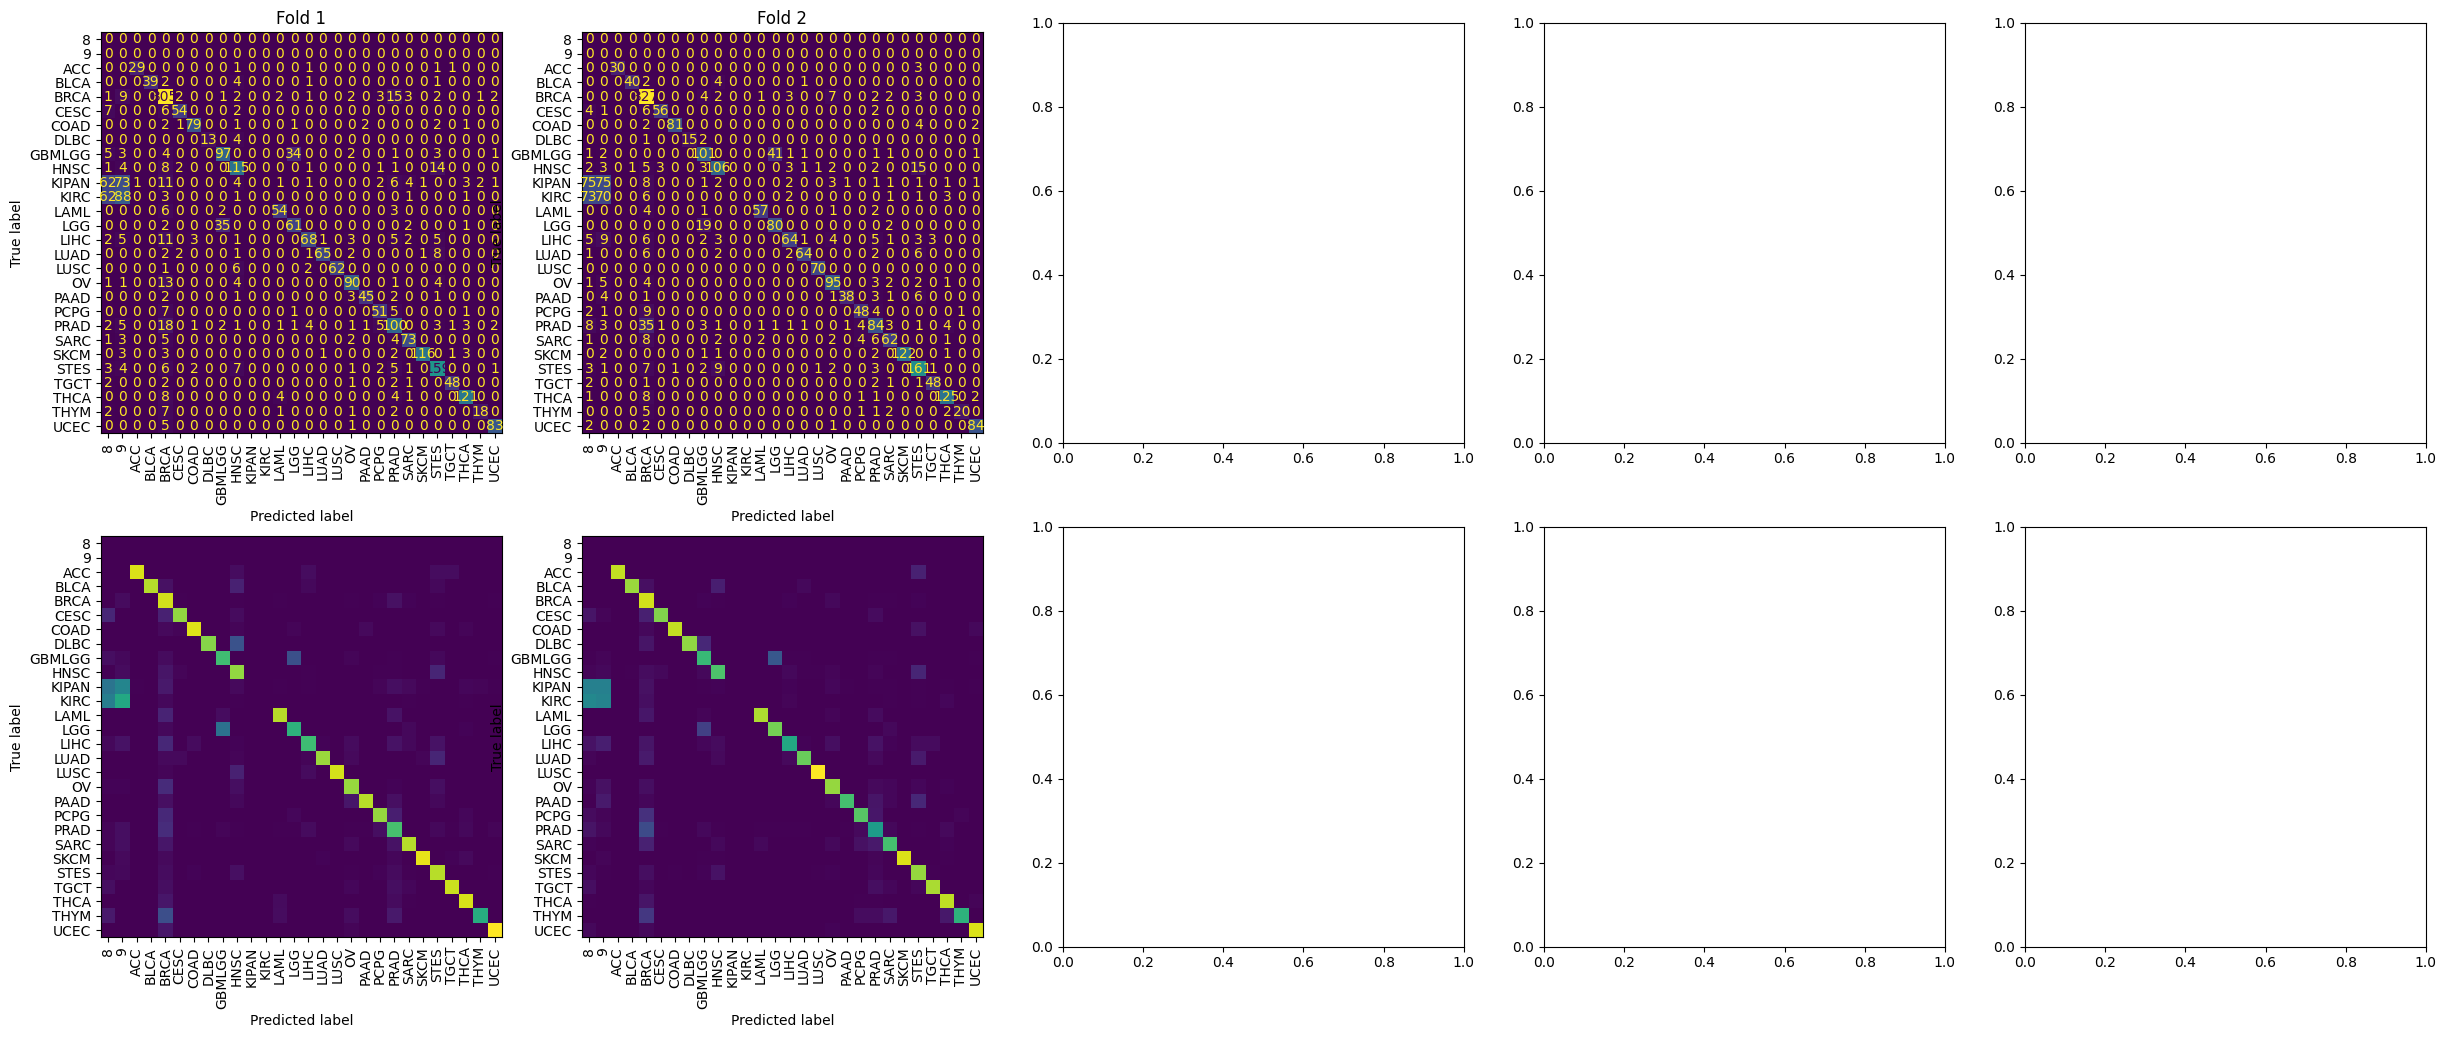

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.misc import derivative
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler

def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
  a,g = alpha, gamma
  y_true = dtrain.label
  # N observations x num_class arrays
  y_true = np.eye(num_class)[y_true.astype('int')]
  y_pred = y_pred.reshape(-1,num_class, order='F')
  # alpha and gamma multiplicative factors with BCEWithLogitsLoss
  def fl(x,t):
      p = 1/(1+np.exp(-x))
      return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  # flatten in column-major (Fortran-style) order
  return grad.flatten('F'), hess.flatten('F')

def standardization(predicted):
    X_mean = predicted.mean(axis=1, keepdims=True)
    X_std = predicted.std(axis=1, keepdims=True)
    return (predicted - X_mean) / X_std

X, y = X_tr_final, y_tr_final
X_K = X_tr_final_K
FOLDNUM = 5

# n-fold CV를 위한 boolean mask 준비
skf = StratifiedKFold(n_splits=FOLDNUM, shuffle=True, random_state=RSEED)
boolean_masks = []
for train_idx, test_idx in skf.split(X, y):
    mask = np.zeros(X.shape[0], dtype=bool)
    mask[test_idx] = True
    boolean_masks.append(mask)
#

fig, axes = plt.subplots(2, FOLDNUM, figsize=(30,12))
scorelist = []

for foldidx, valid_mask in enumerate(boolean_masks):
  train_mask = ~valid_mask
  X_train, X_valid = X[train_mask], X[valid_mask]
  X_train_K, X_valid_K = X_K[train_mask], X_K[valid_mask]
  y_train, y_valid = y[train_mask], y[valid_mask]

  # model2 = LGBMClassifier(**LGBM_PARAM)
  # model2.fit(X_train, y_train)

  y_train = y_train.apply(lambda x: SUBCLASS_ENCODED[x])
  lgbtrain = lgb.Dataset(X_train, y_train, free_raw_data=True)
  lgbeval = lgb.Dataset(X_valid, y_valid)

  ALPHA, GAMMA, CLASS_NUM, NUM_BOOST = 0.25, 1.0, 26, 400
  focal_loss = lambda x,y: focal_loss_lgb(x, y, ALPHA, GAMMA, CLASS_NUM)
  eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, ALPHA, GAMMA, CLASS_NUM)
  params = dict(
      learning_rate=0.05,
      num_class=CLASS_NUM,
      objective=focal_loss,
      verbosity=-1,
      boosting_type='gbdt',
      num_leaves=25,
      reg_alpha=0,
      reg_lambda=0,
      min_child_samples=10,
      # min_split_gain=1,
      min_child_weight=1e-3,
      # early_stopping=20,
  )
  model = lgb.train(params, lgbtrain, num_boost_round=NUM_BOOST)

  y_pred = model.predict(X_valid)

  # y_pred_proba_1 = model.predict(X_valid)
  # y_pred_proba_2 = model2.predict_proba(X_valid)

  # y_pred_proba_1 = standardization(y_pred_proba_1)
  # y_pred_proba_2 = standardization(y_pred_proba_2)
  # y_pred = (y_pred_proba_1 + y_pred_proba_2)
  y_pred = np.vectorize(lambda x: SUBCLASS_LABEL[x])(y_pred.argmax(axis=1))
  # temp = y_pred == 'KIRC'
  # y_pred[y_pred == 'KIPAN'] = 'KIRC'
  # y_pred[temp] = 'KIPAN'

    ### For KIPAN, KIRC

  # y_train_K = y_train[(y_train == 8) | (y_train == 9)]
  # X_train_K = X_train_K[(y_train == 8) | (y_train == 9)]
  # X_valid_K = X_valid_K[(y_pred == 'KIPAN') | (y_pred == 'KIRC')]

  # model_K = LGBMClassifier(**LGBM_PARAM_K)
  # model_K.fit(X_train_K, y_train_K)
  # y_pred_K_new = model_K.predict(X_valid_K)

  # # 값 대체
  # outer_idx = 0
  # for i in range(len(y_pred)):
  #   if y_pred[i] in ['KIPAN', 'KIRC']:
  #     y_pred[i] = y_pred_K_new[outer_idx]
  #     outer_idx += 1

  ### KIPAN, KIRC End

  for title, normalize in [(f"Fold {foldidx+1}", None), ("", 'true')]:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_valid, y_pred,
        # display_labels=MUT_LIST,
        cmap='viridis',
        normalize=normalize,
        xticks_rotation='vertical',
        ax=axes[int(normalize == 'true'), foldidx],
        colorbar=False,
        include_values=(normalize != 'true')
    )
    disp.ax_.set_title(title)

  scorelist.append(f1_score(y_valid, y_pred, average='macro'))
  print(f"### Fold {foldidx+1} ### Macro F1 Score: {f1_score(y_valid, y_pred, average='macro')}")

print(f"\n### Average: {sum(scorelist) / FOLDNUM}")
fig.tight_layout()

## 1 fold validation

In [34]:
# train-test-split
from sklearn.model_selection import train_test_split

X = X_tr_final; y = y_tr_final
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)
X_train, y_train = X, y
print(Counter(y_train))

Counter({'BRCA': 1756, 'STES': 955, 'KIPAN': 858, 'KIRC': 781, 'PRAD': 756, 'GBMLGG': 749, 'HNSC': 735, 'THCA': 692, 'SKCM': 644, 'OV': 569, 'LIHC': 529, 'LGG': 507, 'COAD': 446, 'UCEC': 445, 'SARC': 440, 'LUAD': 414, 'LUSC': 352, 'CESC': 343, 'LAML': 327, 'PCPG': 325, 'TGCT': 279, 'PAAD': 268, 'BLCA': 234, 'ACC': 162, 'THYM': 155, 'DLBC': 86})


In [35]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

def eval_f1score(y_true, y_pred):
  return ("Macro_F1_Score", f1_score(y_true, np.argmax(y_pred, axis=1), average='macro'), False)

LGBM_PARAM = dict(
    boosting_type='gbdt',
    num_leaves=20,
    verbose=-1,
    reg_alpha=0,
    reg_lambda=0,
    n_estimators=400,
    learning_rate=0.1,
    # min_child_samples=30,
    importance_type='gain',
    class_weight='balanced',
)

evals={}
model = LGBMClassifier(**LGBM_PARAM)
# model.fit(X_train, y_train, eval_metric=eval_f1score, eval_set=[(X_valid, y_valid)], callbacks=[lgb.record_evaluation(evals)])
# lgb.plot_metric(evals)
model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', importance_type='gain',
               n_estimators=400, num_leaves=20, reg_alpha=0, reg_lambda=0,
               verbose=-1)

In [ ]:
# # Undersampling
# from imblearn.under_sampling import RandomUnderSampler
# US = {
#     "BRCA": 900,
# }
# CLIP_TO = 1000

# undersampling_cnt = dict(y_train.value_counts().clip(upper=CLIP_TO))
# # undersampling_cnt = dict(y_train.value_counts())
# # for k, v in US.items():
# #   undersampling_cnt[k] = v
# undersample = RandomUnderSampler(sampling_strategy=undersampling_cnt)
# X_train, y_train = undersample.fit_resample(X_train, y_train)

# # Oversampling
# from imblearn.over_sampling import SMOTE

# print(Counter(y_train))
# sm = SMOTE(random_state=RSEED)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(Counter(y_train))

Counter({'BRCA': 1000, 'STES': 764, 'KIPAN': 686, 'KIRC': 625, 'PRAD': 605, 'GBMLGG': 599, 'HNSC': 588, 'THCA': 553, 'SKCM': 515, 'OV': 455, 'LIHC': 423, 'LGG': 406, 'COAD': 357, 'UCEC': 356, 'SARC': 352, 'LUAD': 331, 'LUSC': 282, 'CESC': 274, 'LAML': 262, 'PCPG': 260, 'TGCT': 223, 'PAAD': 214, 'BLCA': 187, 'ACC': 130, 'THYM': 124, 'DLBC': 69})
Counter({'ACC': 1000, 'BLCA': 1000, 'BRCA': 1000, 'CESC': 1000, 'COAD': 1000, 'DLBC': 1000, 'GBMLGG': 1000, 'HNSC': 1000, 'KIPAN': 1000, 'KIRC': 1000, 'LAML': 1000, 'LGG': 1000, 'LIHC': 1000, 'LUAD': 1000, 'LUSC': 1000, 'OV': 1000, 'PAAD': 1000, 'PCPG': 1000, 'PRAD': 1000, 'SARC': 1000, 'SKCM': 1000, 'STES': 1000, 'TGCT': 1000, 'THCA': 1000, 'THYM': 1000, 'UCEC': 1000})


In [12]:
# Focal Loss Test
from scipy.misc import derivative
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler

def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
  a,g = alpha, gamma
  y_true = dtrain.label
  # N observations x num_class arrays
  y_true = np.eye(num_class)[y_true.astype('int')]
  y_pred = y_pred.reshape(-1,num_class, order='F')
  # alpha and gamma multiplicative factors with BCEWithLogitsLoss
  def fl(x,t):
      p = 1/(1+np.exp(-x))
      return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  # flatten in column-major (Fortran-style) order
  return grad.flatten('F'), hess.flatten('F')

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False

y_train_enc = y_train.apply(lambda x: SUBCLASS_ENCODED[x])
# y_valid_enc = y_valid.apply(lambda x: SUBCLASS_ENCODED[x])
lgbtrain = lgb.Dataset(X_train, y_train_enc, free_raw_data=True)
# lgbeval = lgb.Dataset(X_valid, y_valid_enc)

# undersampling_cnt = dict(y_train_enc.value_counts().clip(upper=750))
# undersample = RandomUnderSampler(sampling_strategy=undersampling_cnt, random_state=RSEED)
# X_train, y_train_enc = undersample.fit_resample(X_train, y_train_enc)

ALPHA, GAMMA, CLASS_NUM, NUM_BOOST = 0.25, 1.0, 26, 400
focal_loss = lambda x,y: focal_loss_lgb(x, y, ALPHA, GAMMA, CLASS_NUM)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, ALPHA, GAMMA, CLASS_NUM)
params = dict(
    learning_rate=0.05,
    num_class=CLASS_NUM,
    objective=focal_loss,
    verbosity=-1,
    boosting_type='gbdt',
    num_leaves=25,
    reg_alpha=0,
    reg_lambda=0,
    min_child_samples=10,
    # min_split_gain=1,
    min_child_weight=1e-3,
    # early_stopping=20,
)
# model = lgb.train(params, lgbtrain, fobj=focal_loss)
evals={}
# model = lgb.train(params, lgbtrain, valid_sets=[lgbeval], feval=eval_error, num_boost_round=NUM_BOOST, callbacks=[lgb.record_evaluation(evals)])
model = lgb.train(params, lgbtrain, num_boost_round=NUM_BOOST)
# lgb.plot_metric(evals)
# print(f"min loss: {min(evals['valid_0']['focal_loss'])}")
# cv_results = lgb.cv(params, lgbtrain, nfold=5, num_boost_round=10, stratified=True, seed=RSEED, feval=eval_error)

In [ ]:
for i in range(0, len(evals['valid_0']['focal_loss']), 45):
  print(f"{i}th: {evals['valid_0']['focal_loss'][i]}")

0th: 0.23694091660222993
45th: 0.029684016909641515
90th: 0.01544758926139608
135th: 0.01263680407864703
180th: 0.011512683318835553
225th: 0.011116685486104576
270th: 0.011026931069418275
315th: 0.01108940330276204
360th: 0.011256393695039195


In [28]:
y_pred = model.predict(X_valid)

In [ ]:
y_pred = np.vectorize(lambda x: SUBCLASS_LABEL[x])(y_pred.argmax(axis=1))

## 따로 훈련

In [36]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

y_train_K = y_train[(y_train == 'KIPAN') | (y_train == 'KIRC')]
X_train_K = X_train[(y_train == 'KIPAN') | (y_train == 'KIRC')]

LGBM_PARAM_K = dict(
    boosting_type='gbdt',
    num_leaves=20,
    verbose=-1,
    reg_alpha=0,
    reg_lambda=0,
    n_estimators=10,
    learning_rate=0.1,
    min_child_samples=20,
    importance_type='gain',
    # class_weight='balanced',
)

model_K = LGBMClassifier(**LGBM_PARAM_K)
model_K.fit(X_train_K, y_train_K)

LGBMClassifier(importance_type='gain', n_estimators=10, num_leaves=20,
               reg_alpha=0, reg_lambda=0, verbose=-1)

In [37]:
from lightgbm import LGBMClassifier

y_train_L = y_train[(y_train == 'LGG') | (y_train == 'GBMLGG')]
X_train_L = X_train[(y_train == 'LGG') | (y_train == 'GBMLGG')]

LGBM_PARAM_L = dict(
    boosting_type='gbdt',
    num_leaves=20,
    verbose=-1,
    reg_alpha=0,
    reg_lambda=0,
    n_estimators=100,
    learning_rate=0.02,
    min_child_samples=10,
    importance_type='gain',
    # class_weight='balanced',
)

model_L = LGBMClassifier(**LGBM_PARAM_L)
model_L.fit(X_train_L, y_train_L)

In [32]:
X_predicted_as_K = X_valid[(y_pred == 'KIPAN') | (y_pred == 'KIRC')]
y_pred_K_new = model_K.predict(X_predicted_as_K)

X_predicted_as_L = X_valid[(y_pred == 'LGG') | (y_pred == 'GBMLGG')]
y_pred_L_new = model_L.predict(X_predicted_as_L)

outer_idx = 0
for i in range(len(y_pred)):
  if y_pred[i] in ['LGG', 'GBMLGG']:
    y_pred[i] = y_pred_L_new[outer_idx]
    outer_idx += 1

outer_idx = 0
for i in range(len(y_pred)):
  if y_pred[i] in ['KIPAN', 'KIRC']:
    y_pred[i] = y_pred_K_new[outer_idx]
    outer_idx += 1

# Metrics

Macro F1 Score: 0.800038110035312


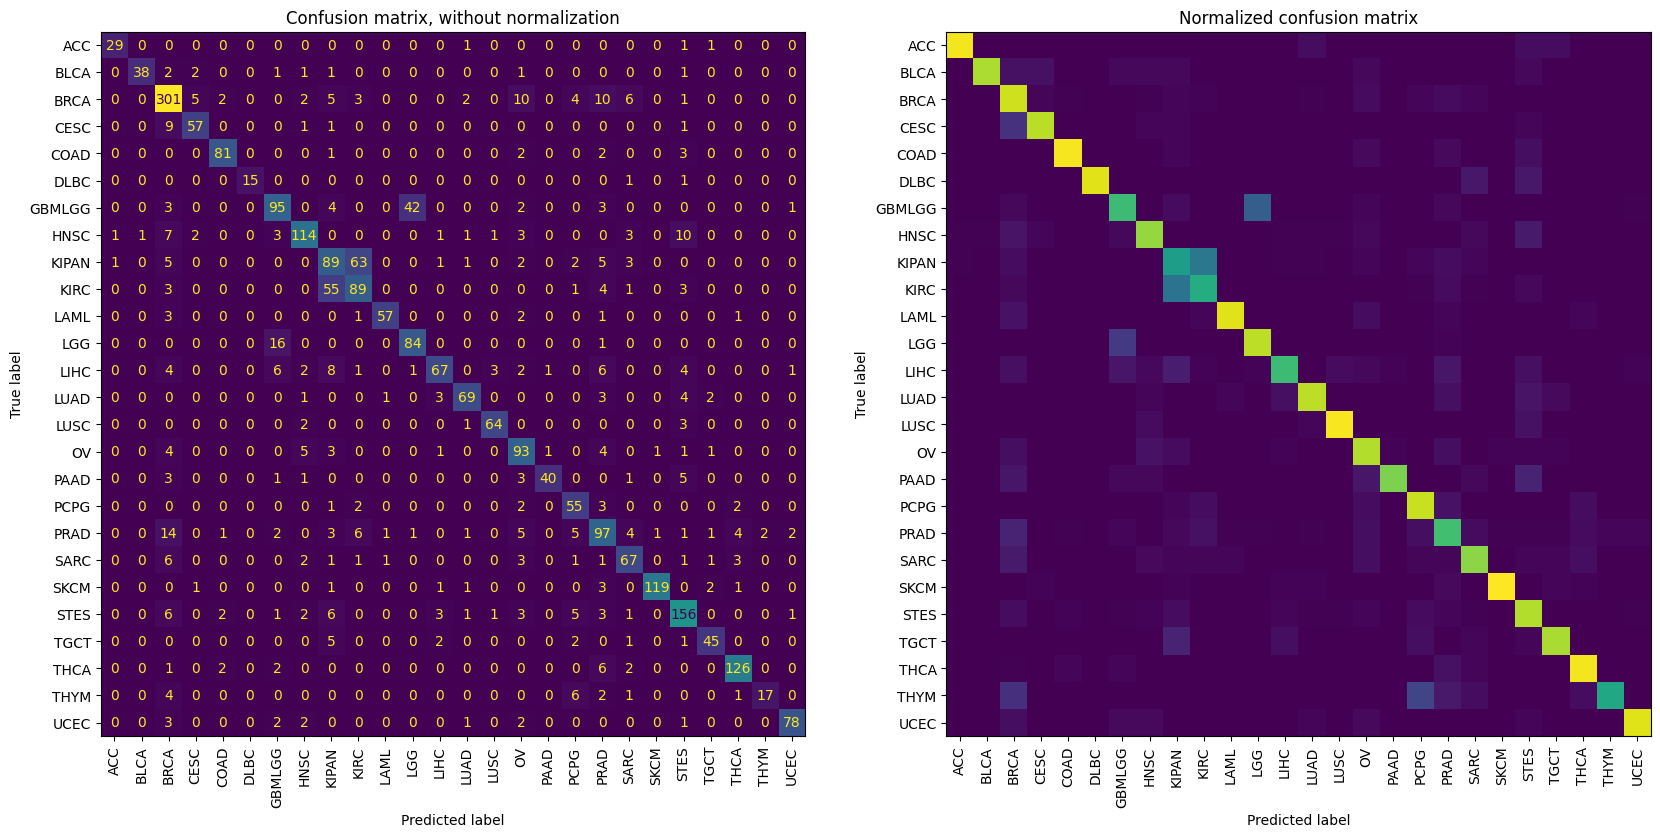

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, classification_report

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
fig, axes = plt.subplots(1, 2, figsize=(20,10))
np.set_printoptions(precision=2); i=0

for title, normalize in titles_options:
  disp = ConfusionMatrixDisplay.from_predictions(
      y_valid, y_pred,
      # display_labels=MUT_LIST,
      cmap='viridis',
      normalize=normalize,
      xticks_rotation='vertical',
      ax=axes[i],
      colorbar=False,
      include_values=(normalize != 'true')
  )
  disp.ax_.set_title(title)
  i += 1

print(f"Macro F1 Score: {f1_score(y_valid, y_pred, average='macro')}")

In [ ]:
report = classification_report(y_valid, y_pred)
print(report)

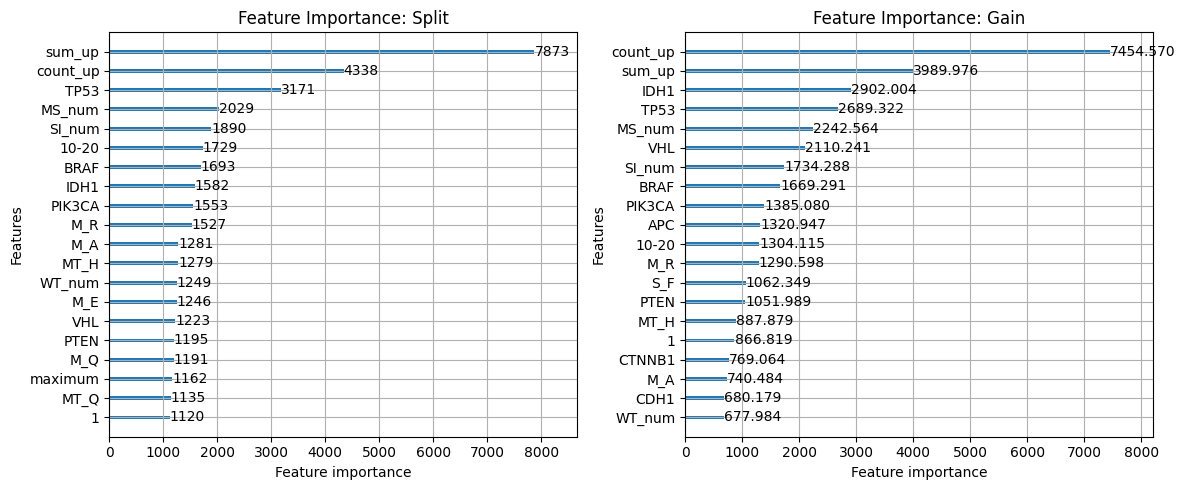

In [ ]:
import lightgbm

# For LightGBM
def lgbm_FI(model):
  fig, axes = plt.subplots(1, 2, figsize=(12,5))
  lightgbm.plot_importance(model, max_num_features=20, importance_type='split', title="Feature Importance: Split", ax=axes[0])
  lightgbm.plot_importance(model, max_num_features=20, importance_type='gain', title="Feature Importance: Gain", ax=axes[1])
  fig.tight_layout()

# For Logistic
def lr_FI(model, X_train):
  weights = model.coef_[0] * (X_train.max(axis=0) - X_train.min(axis=0)) / X_train.std(axis=0)

  # Sort the weights in descending order
  sorted_idx = weights.argsort()[::-1]
  for i in sorted_idx:
    print(f"{X_train.columns[i]}: {weights[i]}")

lgbm_FI(model)

<Axes: >

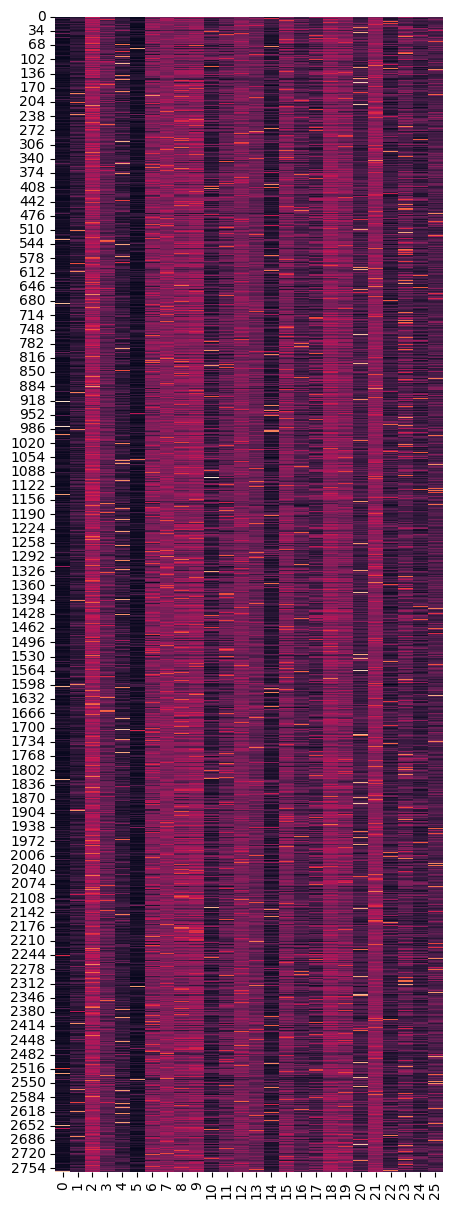

In [ ]:
temp = y_pred#[((y_valid == 'KIPAN') | (y_valid == 'KIRC'))]

fig, ax = plt.subplots(figsize=(5,15))
sns.heatmap(temp, ax=ax, cbar=None)

In [ ]:
temp[:5]

array([[-8.83, -6.31, -3.59, -5.36,  3.33, -9.  , -2.64, -2.4 , -4.66,
        -3.32, -7.81, -4.87, -4.41, -5.9 , -7.43, -3.52, -3.29, -6.93,
        -4.07, -5.11, -7.63, -1.92, -7.33, -7.12, -6.55, -6.26],
       [-8.53, -7.08, -2.21, -5.39, -7.68, -9.41, -4.35, -2.61, -4.64,
        -3.76, -8.01, -6.3 , -1.81, -4.87, -6.93, -2.37, -5.91, -6.84,
        -4.17, -3.71, -7.35, -2.81, -6.32, -7.19, -8.01, -6.06],
       [-9.41, -8.24, -1.33, -5.5 , -8.41, -9.45, -4.11, -4.5 , -3.15,
        -2.62, -4.05, -4.95, -3.99, -5.93, -8.51, -4.04, -6.75, -3.21,
        -2.44, -2.96, -6.63, -4.14, -6.64, -3.  , -5.12, -6.36],
       [-9.28, -7.93, -3.34, -5.91, -7.  , -9.28, -1.56, -5.45, -3.96,
        -2.69, -5.16,  1.04, -3.96, -4.57, -8.39, -4.1 , -5.58, -4.51,
        -3.56, -3.98, -5.78, -4.25, -8.27, -5.33, -4.83, -6.58],
       [-7.03, -7.08, -4.77, -5.39, -7.64, -9.36, -6.31, -2.63, -6.24,
        -6.07, -7.73, -6.77, -4.83, -3.1 , -0.03, -6.86, -7.73, -7.44,
        -5.59, -4.22, -7.83, -

# 제출

In [39]:
y_test_pred = model.predict(X_te_final)
# y_test_pred = np.vectorize(lambda x: SUBCLASS_LABEL[x])(y_test_pred.argmax(axis=1))

In [40]:
X_predicted_as_K = X_te_final[(y_test_pred == 'KIPAN') | (y_test_pred == 'KIRC')]
y_test_pred_K_new = model_K.predict(X_predicted_as_K)

X_predicted_as_L = X_te_final[(y_test_pred == 'LGG') | (y_test_pred == 'GBMLGG')]
y_test_pred_L_new = model_L.predict(X_predicted_as_L)

outer_idx = 0
for i in range(len(y_test_pred)):
  if y_test_pred[i] in ['LGG', 'GBMLGG']:
    y_test_pred[i] = y_test_pred_L_new[outer_idx]
    outer_idx += 1

outer_idx = 0
for i in range(len(y_test_pred)):
  if y_test_pred[i] in ['KIPAN', 'KIRC']:
    y_test_pred[i] = y_test_pred_K_new[outer_idx]
    outer_idx += 1

In [41]:
pd.concat([test.iloc[:, 0], pd.Series(y_test_pred, name='SUBCLASS')], axis=1).to_csv("submission.csv", index=False)

In [ ]:
!pip list

Package                          Version
-------------------------------- -------------------
absl-py                          1.4.0
accelerate                       0.34.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.16
albumentations                   1.4.15
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.19.0
astropy                          6.1.3
astropy-iers-data                0.2024.9.16.0.32.21
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread                        3.0.1
autograd                 